### Library Import

In [ ]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from lightgbm import LGBMClassifier


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Data Load

In [ ]:
# 파일 호출
data_path: str = "../data/raw"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [ ]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:05<00:00, 20.74it/s]


### Rename 이후 EDA

In [ ]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    'hourly_network-data_block-interval_block_interval':'block_interval',
    'hourly_network-data_block-count_block_count':'block_count',
    'hourly_network-data_block-bytes_block_bytes':'block_bytes',
    'hourly_network-data_blockreward_blockreward':'blockreward',
    'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
    'hourly_network-data_tokens-transferred_tokens_transferred_total': 'token_transferred',
    'hourly_network-data_tokens-transferred_tokens_transferred_mean':
    'token_transferred_mean',
    'hourly_network-data_tokens-transferred_tokens_transferred_median':
    'token_transferred_median',
    'hourly_network-data_hashrate_hashrate':
    'hashrate',
    'hourly_network-data_difficulty_difficulty':
    'difficulty',
    'hourly_network-data_fees_fees_total':
    'fees',
    'hourly_network-data_velocity_velocity_supply_total':
    'velocity_supply',
    'hourly_network-data_utxo-count_utxo_count':
    'utxo_count',
    'hourly_network-data_supply_supply_total':
    'supply_total',
    'hourly_network-data_supply_supply_new':
    'supply_new',
    'hourly_network-data_fees_fees_block_mean':
    'fees_block_mean',
    'hourly_network-data_fees-transaction_fees_transaction_median':
    'fees_transaction_median',



}

df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape


(11552, 33)

# market data eda

## Market Data 추출

In [ ]:
# 'hourly_market'로 시작하는 열 이름을 필터링
hourly_market_columns = [col for col in cols_dict.keys() if col.startswith('hourly_market')]

# 해당 열만 추출하여 새로운 데이터프레임 생성
df_hourly_market = df[['ID',"_type","target","coinbase_premium_gap","funding_rates","long_liquidations","short_liquidations",
                       "open_interest","buy_ratio","buy_sell_ratio","buy_volume", "sell_ratio","sell_volume",]]

# 결과 확인
df_hourly_market.head()


,ID,_type,target,coinbase_premium_gap,funding_rates,long_liquidations,short_liquidations,open_interest,buy_ratio,buy_sell_ratio,buy_volume,sell_ratio,sell_volume
0,2023-01-01 00:00:00,train,2.0,-9.86,0.005049,0.012,0.000,6.271344e+09,0.475003,0.904774,4.648309e+07,0.524997,5.137537e+07
1,2023-01-01 01:00:00,train,1.0,-8.78,0.005049,0.000,0.712,6.288683e+09,0.623454,1.655721,3.975599e+07,0.376546,2.401129e+07
2,2023-01-01 02:00:00,train,1.0,-9.59,0.005049,0.000,0.000,6.286796e+09,0.506785,1.027512,2.405402e+07,0.493215,2.340995e+07
3,2023-01-01 03:00:00,train,1.0,-9.74,0.005067,0.593,0.000,6.284575e+09,0.466518,0.874477,2.860215e+07,0.533482,3.270773e+07
4,2023-01-01 04:00:00,train,2.0,-10.14,0.006210,0.361,0.000,6.291582e+09,0.491559,0.966796,3.087720e+07,0.508441,3.193766e+07


## Market Data 결측치 탐색

In [ ]:
eda_df = df_hourly_market.loc[df_hourly_market["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

,0
coinbase_premium_gap,0.057078
ID,0.000000
_type,0.000000
target,0.000000
funding_rates,0.000000
long_liquidations,0.000000
short_liquidations,0.000000
open_interest,0.000000
buy_ratio,0.000000
buy_sell_ratio,0.000000


coinbase_premium_gap 데이터에 5%의 결측치가 있는 것을 발견했습니다. 데이터의 분포를 확인한 후에 결측치를 어떻게 처리할지 결정하겠습니다.

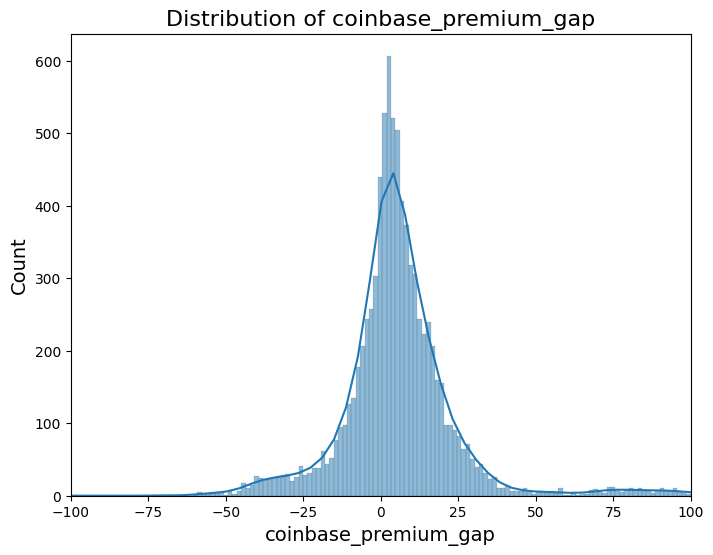

In [ ]:
# 데이터의 분포 확인
plt.figure(figsize=(8, 6))
sns.histplot(eda_df['coinbase_premium_gap'].dropna(), kde=True)

# x축의 범위를 -100 ~ 100으로 조정
plt.xlim(-100, 100)

# 제목과 축 레이블 추가
plt.title('Distribution of coinbase_premium_gap', fontsize=16)
plt.xlabel('coinbase_premium_gap', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

그래프를 통해 대부분의 분포가 0 근처에 집중되어 있다는 것을 알 수 있습니다. 대부분의 값이 중앙에 몰려 있는 것을 볼 수 있기 때문에 결측치 값은 median을 통해 처리하도록 하겠습니다.

In [ ]:
# 중앙값 계산 후 결측치 채우기
median_value = eda_df['coinbase_premium_gap'].median()
eda_df['coinbase_premium_gap'].fillna(median_value, inplace=True)

<ipython-input-35-87b6f869cac9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['coinbase_premium_gap'].fillna(median_value, inplace=True)


In [ ]:
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

,0
ID,0.0
_type,0.0
target,0.0
coinbase_premium_gap,0.0
funding_rates,0.0
long_liquidations,0.0
short_liquidations,0.0
open_interest,0.0
buy_ratio,0.0
buy_sell_ratio,0.0


In [ ]:
# _type이 'train'인 데이터만 필터링하고 ID 열 제거
eda_df_train = eda_df[eda_df['_type'] == 'train'].drop(columns=['ID'])
eda_df_train = eda_df_train.drop(columns=['_type'])
# 결과 확인
eda_df_train.head()


,target,coinbase_premium_gap,funding_rates,long_liquidations,short_liquidations,open_interest,buy_ratio,buy_sell_ratio,buy_volume,sell_ratio,sell_volume
0,2.0,-9.86,0.005049,0.012,0.000,6.271344e+09,0.475003,0.904774,4.648309e+07,0.524997,5.137537e+07
1,1.0,-8.78,0.005049,0.000,0.712,6.288683e+09,0.623454,1.655721,3.975599e+07,0.376546,2.401129e+07
2,1.0,-9.59,0.005049,0.000,0.000,6.286796e+09,0.506785,1.027512,2.405402e+07,0.493215,2.340995e+07
3,1.0,-9.74,0.005067,0.593,0.000,6.284575e+09,0.466518,0.874477,2.860215e+07,0.533482,3.270773e+07
4,2.0,-10.14,0.006210,0.361,0.000,6.291582e+09,0.491559,0.966796,3.087720e+07,0.508441,3.193766e+07


## 히스토그램을 통한 분포 확인

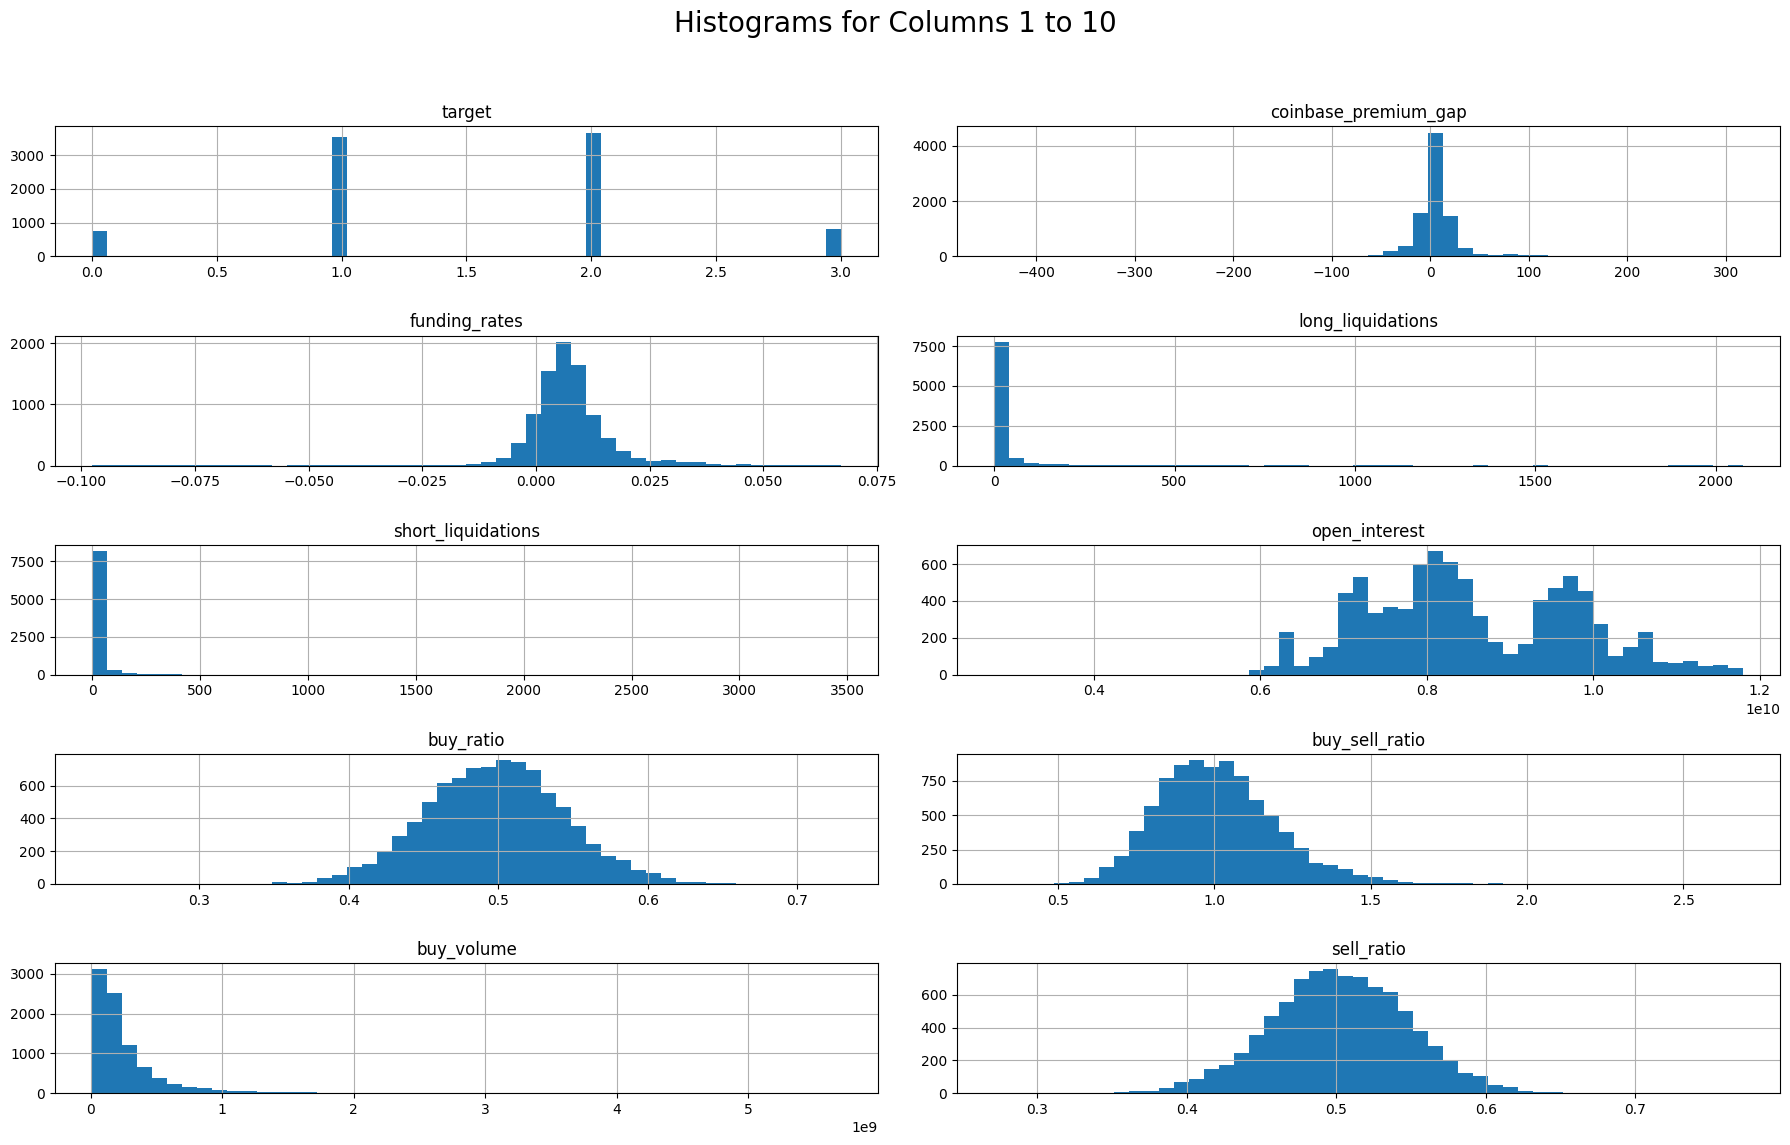

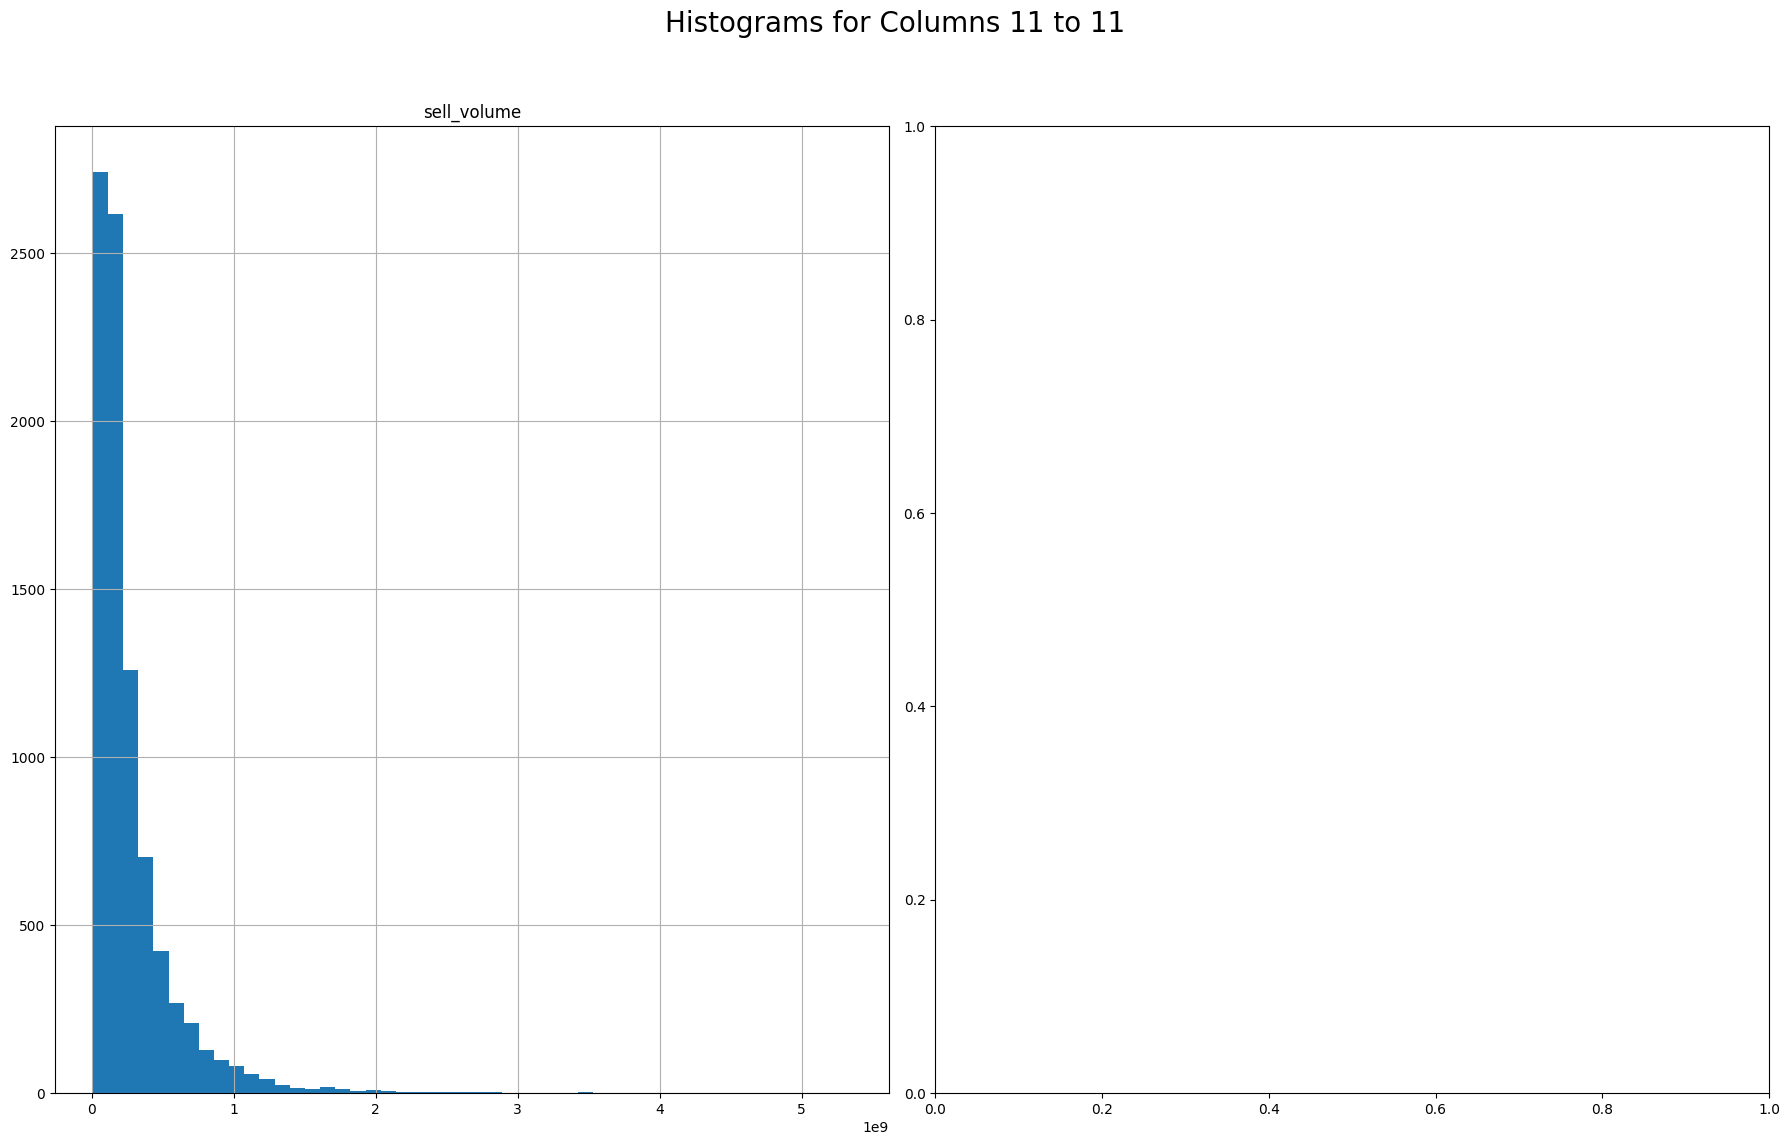

In [ ]:
# eda_df_train_filtered 데이터 복사본 사용
eda_df_train_filtered = eda_df_train.copy()

# 총 열 수
total_columns = eda_df_train_filtered.columns

# 10개씩 나누어 시각화
for i in range(0, len(total_columns), 10):
    # i부터 i+10까지의 열 선택
    sample_columns = total_columns[i:i + 10]

    # 선택한 열에 대해 히스토그램 생성
    fig, axes = plt.subplots(nrows=len(sample_columns)//2 + len(sample_columns)%2, ncols=2, figsize=(18, 12))
    fig.suptitle(f'Histograms for Columns {i+1} to {i+len(sample_columns)}', fontsize=20)

    for idx, col in enumerate(sample_columns):
        ax = axes.flatten()[idx]
        eda_df_train_filtered[col].hist(bins=50, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 히스토그램 결과
- long_liquidations, short_liquidations, buy_volume,sell_volume은 값의 대부분이 한쪽에 치우쳐져 있습니다. 이는 데이터의 불균형을 의미하며, 예측 모델에서 중요한 feature일 가능성이 있습니다.
- buy_ratio, sell_ratio, buy_sell_ratio는 중앙값 근처에 분포하며 정규 분포에 기반한 형태를 보여줍니다.
- coinbase_premium_gap, funding_rates는 좁은 범위에 밀집해 있지만 일부 이상치가 존재합니다. 이상치들은 시장이 정상적이지 않을 때 나타나는 중요한 정보로 작용할 수 있습니다.
- open interest는 다소 넓은 범위에 분포되어 있으며, 중앙값 주변에 데이터가 집중되어 있습니다. 극단적인 open interest는 변동성 확대의 신호로 볼 수 있기에 주의 깊게 분석할 필요가 있습니다.

## Target과의 상관관계 분석

### Feature Importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 10
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109


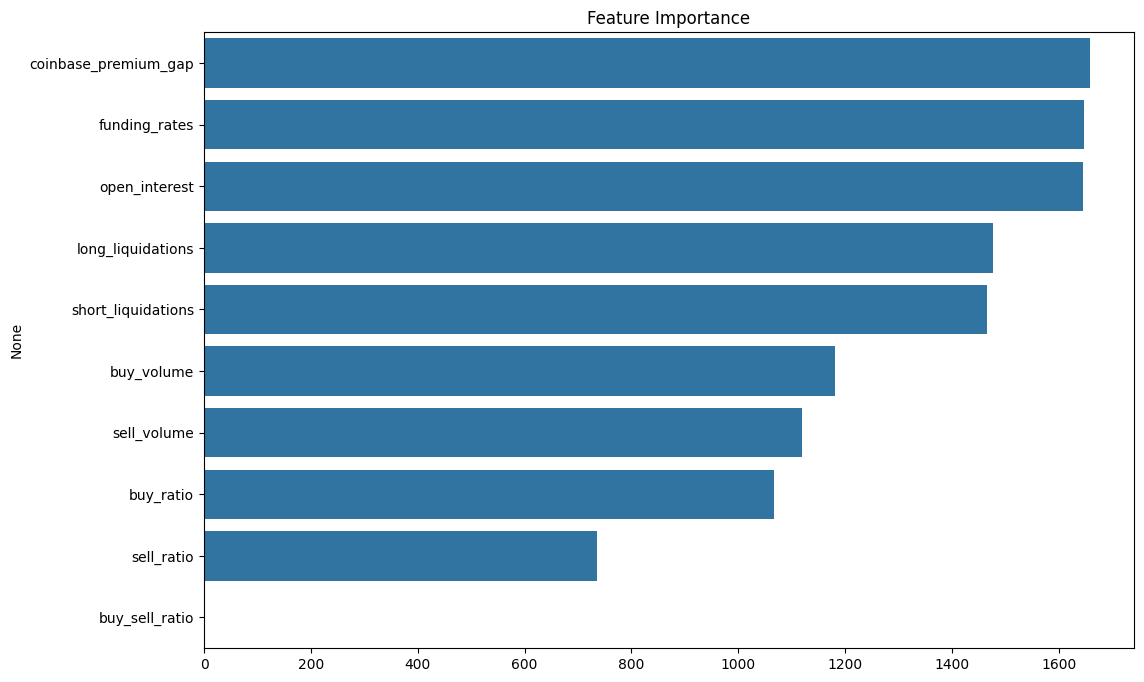

In [ ]:
# LightGBM 모델 학습
lgbm = LGBMClassifier()
X = eda_df_train_filtered.drop(columns=['target'])
y = eda_df_train_filtered['target']

lgbm.fit(X, y)

# 피처 중요도 시각화
feature_importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.show()

- coinbase_premium_gap, funding_rates, open_interest는 모델에서 가장 중요한 feature로 평가됩니다.
- long/short_liquidations도 중요하게 나타나, 청산 거래가 target에 영향을 끼치는 것을 알 수 있습니다.
- buy_ratio, sell_ratio는 비교적 중요도가 낮아, target을 예측하는 데 상대적으로 덜 중요한 역할을 합니다.


### Kendall Tau Correlation Heatmap

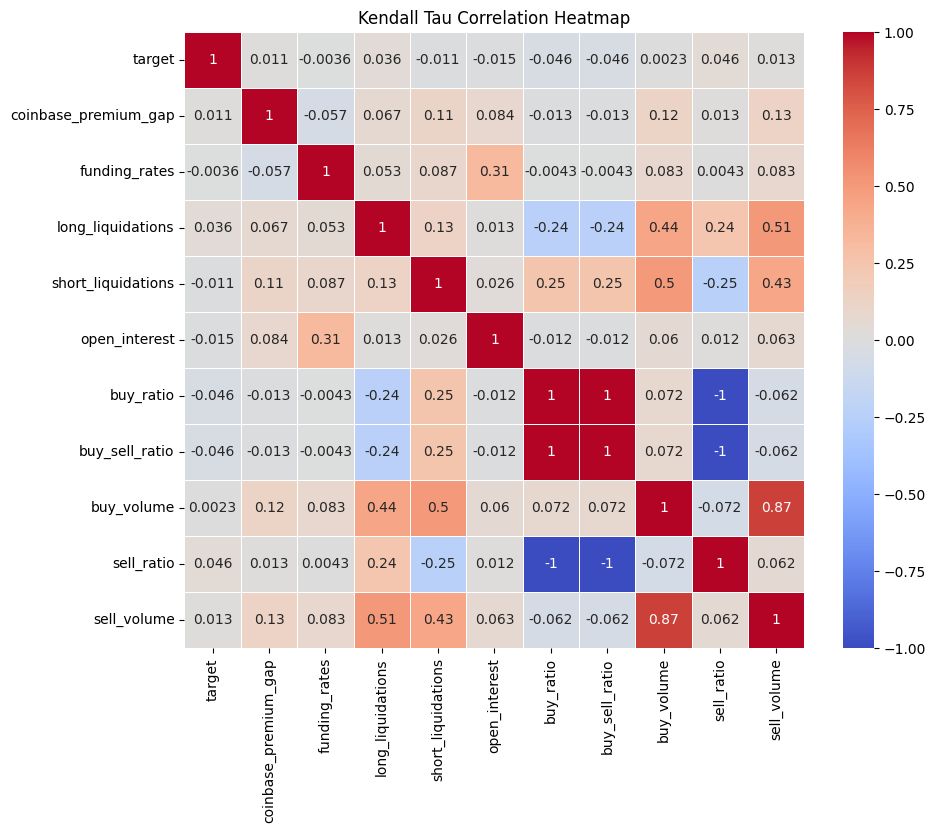

In [ ]:
# Kendall Tau Correlation 계산
kendall_corr = eda_df_train_filtered.corr(method='kendall')

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Kendall Tau Correlation Heatmap")
plt.show()


- buy_ratio, sell_ratio는 완벽한 음의 상관관계를 가집니다. 두 변수가 본질적으로 같은 정보를 제공함을 의미하지만, 이를 제거하기보다는 Feature Engineering을 통해 유의미한 결과를 만들 수 있습니다.
- 모든 변수와 target 간의 상관관계가 크지 않습니다. 직접적인 선형 관계가 없을 수 있음을 의미합니다.
- target을 예측하기 위해서는 비선형 관계를 포착할 수 있는 더 복잡한 모델이 필요할 것입니다.

# 중요도 상위 3개 feature의 target별 분포 시각화

### 1. coinbase_premium_gap

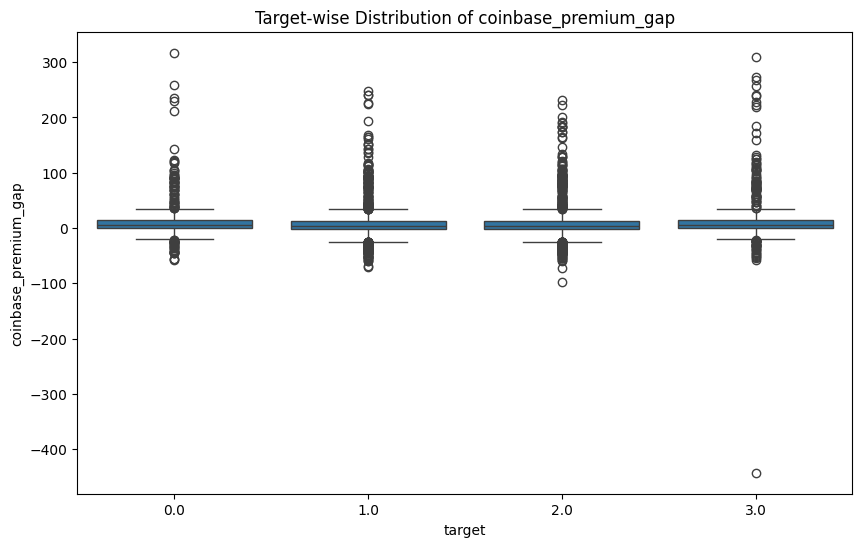

In [ ]:
# 상위 3개 피처 추출
top_3_features = feature_importance.index[:3]

# 타겟별 피처 분포 시각화
feature = top_3_features[0]
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=feature, data=eda_df_train_filtered)
plt.title(f'Target-wise Distribution of {feature}')
plt.show()


- coinbase_premium_gap은 중앙값을 기준으로 안정적인 분포를 보입니다.
- 각 target 값에 따라 유의미한 차이를 보여주지 않기 때문에 타겟 예측에 있어서 큰 영향이 없을 수도 있습니다.
- 하지만, 이상치의 영향은 고려할 필요가 있습니다. 예를 들어, target 값이 3인 경우, 더 높은 프리미엄 갭이 나타나는 경향이 있습니다.


### 2. funding_rates

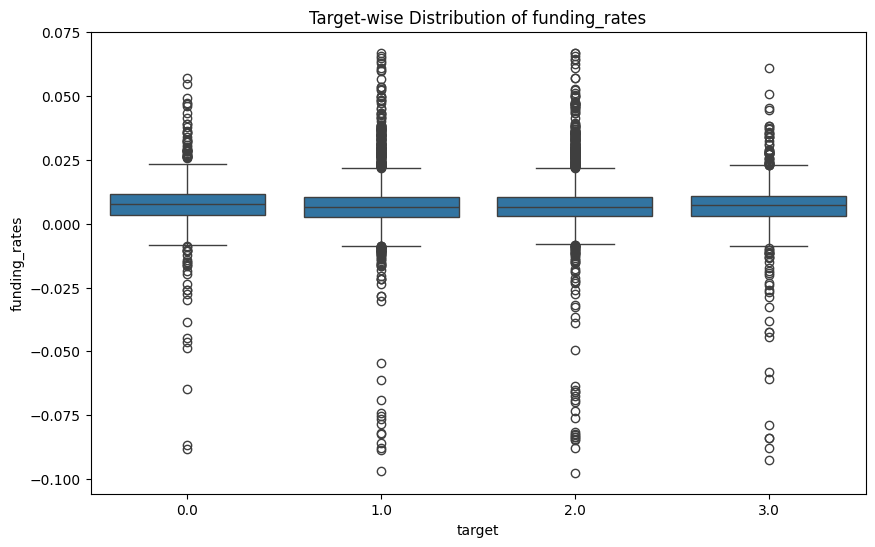

In [ ]:
# 타겟별 피처 분포 시각화
feature = top_3_features[1]
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=feature, data=eda_df_train_filtered)
plt.title(f'Target-wise Distribution of {feature}')
plt.show()


- funding rates의 경우에도 각 target 값에 대한 박스의 범위가 유사하며, 큰 차이가 없습니다.

### 3.open_interest

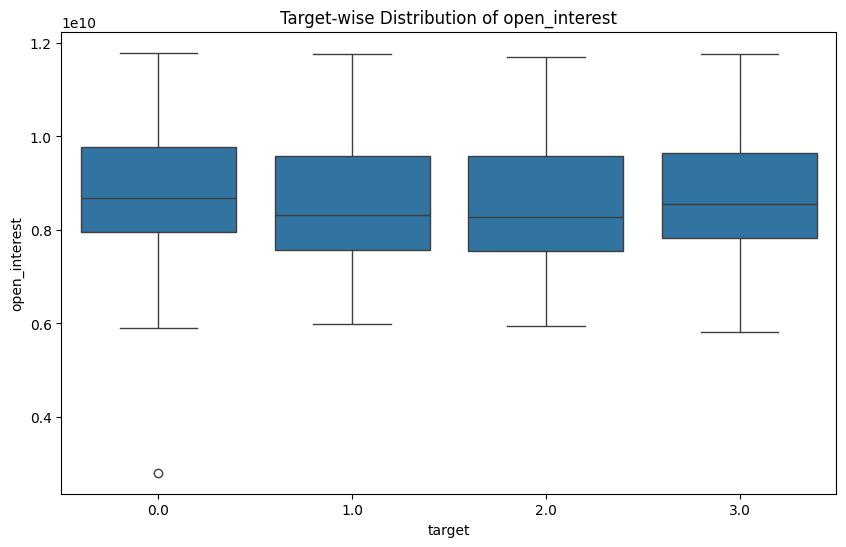

In [ ]:
# 타겟별 피처 분포 시각화
feature = top_3_features[2]
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=feature, data=eda_df_train_filtered)
plt.title(f'Target-wise Distribution of {feature}')
plt.show()

- open_interest 역시도 target 별로 큰 차이를 보여주지 않습니다.
- 따라서, 직접적인 큰 영향을 주는 변수는 아닐 수 있지만, 다른 변수들과의 상호작용을 통해 예측에 기여할 가능성이 있습니다.

# 클러스터링 기반 히트맵

<Figure size 1200x800 with 0 Axes>

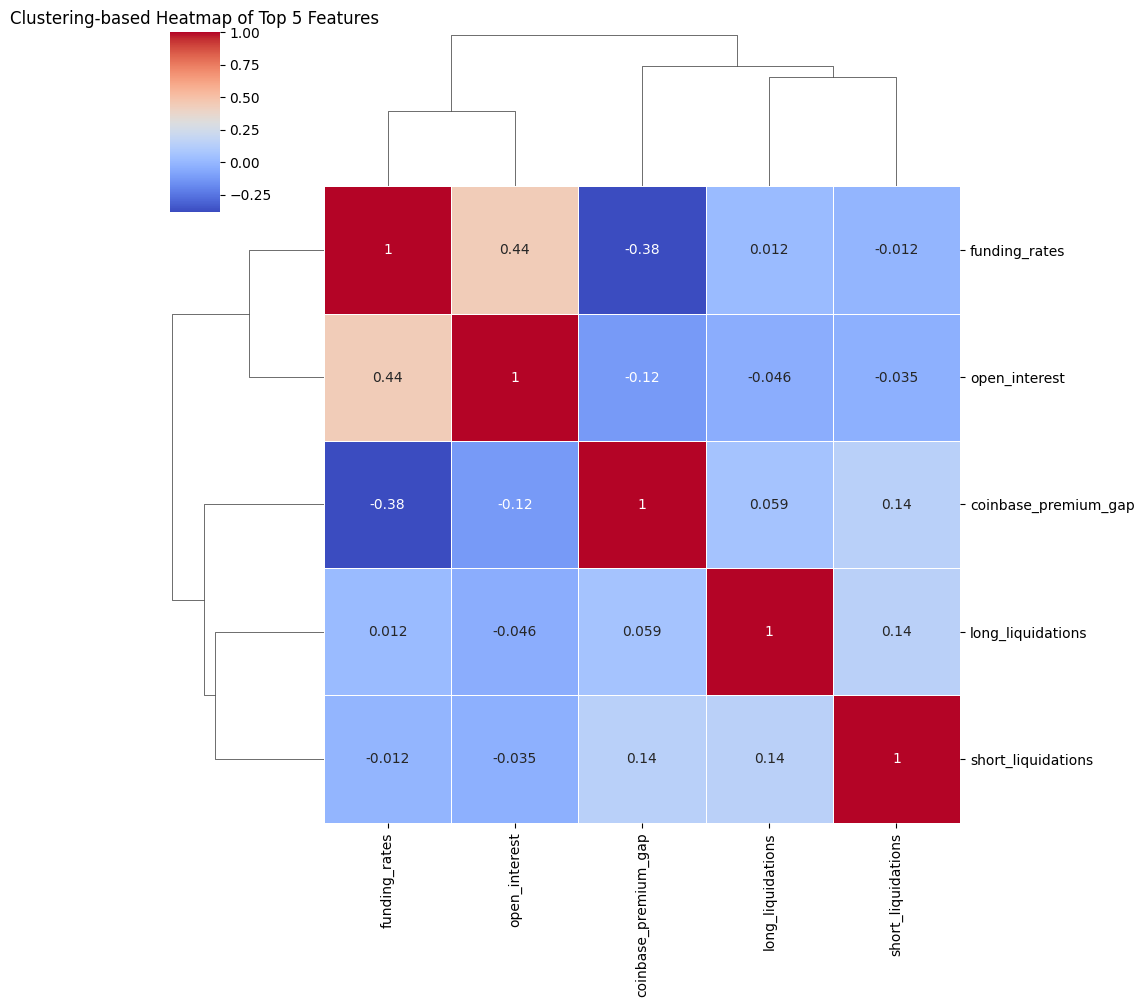

In [ ]:
top_5_features = feature_importance.index[:5]

# 상위 5개의 피처를 대상으로 클러스터링 기반 히트맵 작성
corr_matrix = eda_df_train_filtered[top_5_features].corr()

plt.figure(figsize=(12, 8))
sns.clustermap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Clustering-based Heatmap of Top 5 Features")
plt.show()


- funding_rates와 open_interest는 관련성이 높아 함께 분석이 될 수 있습니다.
- coinbase_premium_gap은 상대적으로 독립적이며, 다른 변수들과 상관관계가 적기 때문에 이 변수가 예측에 있어 독립적인 중요한 feature가 될 수 있습니다.
- long_liquidation와 short_liquidation은 약한 상관관계를 보이며, 두 변수 간에 큰 상관성은 없음을 보여줍니다.